In [2]:
from itertools import chain
from pyspark import StorageLevel
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import pandas as pd
import statsmodels.api as sm
from pyspark.sql.types import *

spark = SparkSession.builder.appName('CorpusLoader').master('local[*]')\
.config('spark.driver.memory','100G') \
    .config("spark.sql.mapKeyDedupPolicy","LAST_WIN") \
    .config("spark.sql.adaptive.optimizeSkewedJoin.enabled", "true") \
    .config("spark.local.dir", "/mnt/simhomes/binzc/sparktemp") \
    .config("spark.executor.memory", "4g")\
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")\
    .config("spark.default.parallelism", "96")\
        .getOrCreate()
    
    

import os
import seaborn as sns
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from matplotlib import pyplot as plt
from pyspark.sql.functions import split, element_at, map_concat,create_map, map_from_entries, when, col, lit, collect_list,expr, arrays_zip, monotonically_increasing_id, transform, arrays_zip, size, slice, collect_list, stddev_pop, avg, col , explode, col, sqrt, pow
from pyspark.sql.types import LongType, IntegerType
from pyspark.sql import functions as f

year_list = list(range(1800, 2001))
dict_years = list(chain.from_iterable(zip([lit(year) for year in year_list], [lit(0) for i in year_list])))
group_column = 'NgramId'
intercept = "ic"
y_column = 'Frequency_N'
x_columns = ['Frequency_L', 'Frequency_R']
schema = StructType([StructField('NgramId', LongType(), True), StructField('Frequency_L', DoubleType(), False), StructField('Frequency_R', DoubleType(), False),StructField('ic',  DoubleType(), True)])


class CorpusLoader:

    def __init__(self, root_path, spark):
        self.__root_path = root_path
        self.__spark = spark

    def load(self):
        #self.__array_df = self.__load_or_create_parquet('array.parquet', self.__create_array_df)
        self.__token_df = self.__load_or_create_parquet('token.parquet', self.__create_token_df)
        self.__contains_df = self.__load_or_create_parquet('contains.parquet', self.__create_contains_df)
        self.__data_df = self.__load_or_create_parquet('data.parquet', self.__create_data_df)

    def __load_or_create_parquet(self, name, create_function):
        parquet_path = os.path.join(os.path.join(self.__root_path, 'parquets'), name)
        
        if not os.path.exists(parquet_path):
            print(f'File "{name}" not found. \n\t -- Creating "{name}" ...')
            
            df = create_function()
            df.write.parquet(parquet_path)

            print('\t -- Done.')

        print(f'Loading "{name}" ...')
        return self.__spark.read.parquet(parquet_path)

    def __create_token_df(self):
        one_gram_path = os.path.join(self.__root_path, '1')

        one_gram_df = spark.read.csv(one_gram_path, sep='\n', quote="").withColumnRenamed('_c0', 'Input')
        token_df = one_gram_df \
                .select(split('Input', '\t').alias('SplitInput')) \
                .select(element_at('SplitInput', 1).alias('Tokens')) \
                .select(explode(split('Tokens', ' ')).alias('Token')) \
                .orderBy('Token') \
                .withColumn('TokenId', monotonically_increasing_id()) 
        
        return token_df

    def __create_array_df(self):
        n_gram_directories = [os.path.join(self.__root_path, x) for x in os.listdir(self.__root_path) if x.isdigit()]
        
        input_df = None

        for path in n_gram_directories:
            new_input_df = spark.read.csv(path, sep='\n', quote="").withColumnRenamed('_c0', 'Input')
            
            if input_df is None:
                input_df = new_input_df
            else:
                input_df = input_df.union(new_input_df)

        split_df = input_df \
                    .select(split('Input', '\t').alias('SplitInput')) \
                    .select(element_at('SplitInput', 1).alias('Tokens'),
                            slice('SplitInput', 2, size('SplitInput')).alias('Data')) \
                    .select(split('Tokens', ' ').alias('Tokens'), 'Data')

        array_df = split_df.select('Tokens', transform('Data', lambda d: split(d, ',')).alias('Data')) \
                    .select('Tokens', transform('Data', lambda x: x[0].cast(IntegerType())).alias('Years'),
                            transform('Data', lambda x: x[1].cast(LongType())).alias('Frequency'),
                            transform('Data', lambda x: x[2].cast(LongType())).alias('BookFrequency')) \
                    .withColumn('NgramId', monotonically_increasing_id())

        return array_df

    def __create_contains_df(self):
        n_gram_df = self.__array_df

        n_gram_to_token_id_df = n_gram_df.select('NgramId', 'Tokens') \
                .select(explode('Tokens').alias('Token'), 'NgramId') \
                .join(self.__token_df, on='Token') \
                .groupBy('NgramId').agg(collect_list('TokenId').alias('TokenIds'))
        print(n_gram_to_token_id_df.count())

        contains_df = n_gram_to_token_id_df.select('NgramId', 'TokenIds') \
            .withColumn('IndexArray', transform('TokenIds', lambda x, i: i)) \
            .select('NgramId', arrays_zip('IndexArray', 'TokenIds').alias('TokenIds')) \
            .select('NgramId', explode('TokenIds').alias('TokenId')) \
            .select('NgramId', 'TokenId.IndexArray', 'TokenId.TokenIds') \
            .withColumnsRenamed({'IndexArray': 'Position', 'TokenIds': 'TokenId'}) \
            .orderBy('NgramId')
        print(contains_df.count())

        return contains_df

    ## This horrific arrays to list of structs to map construct is required, because map_from_arrays zeroes everything out.
    def __create_data_df(self):
        data_df = self.__array_df.select('NgramId', 'Years', 'Frequency', 'BookFrequency')
        data_df = data_df.withColumn('FrequencyStructs', arrays_zip('Years', 'Frequency'))
        data_df = data_df.withColumn('BookFrequencyStructs', arrays_zip('Years', 'BookFrequency'))
        data_df = data_df.withColumn('FrequencyMap', map_from_entries('FrequencyStructs'))
        data_df = data_df.withColumn('BookFrequencyMap', map_from_entries('BookFrequencyStructs'))
        data_df = data_df.select('NgramId', 'FrequencyMap', 'BookFrequencyMap')

        data_df.printSchema()
        
        return data_df.withColumnsRenamed({'FrequencyMap': 'Frequency', 'BookFrequencyMap': 'BookFrequency'})
    
#cl = CorpusLoader('/mnt/c/Users/bincl/BA-Thesis/Dataset/parquets_corpus/', spark)
cl = CorpusLoader('/mnt/simhomes/binzc/data_transfer', spark)

#cl.load()



In [3]:
def build_graph(final_df):
    line_plot = final_df.select("ZScore_N_Array", "ZScoreArray").first()
    years = list(range(1800, 2001))

    pandas_df = pd.DataFrame({
        'ZScore_N_Array': line_plot.ZScore_N_Array,
        'ZScoreArray': line_plot.ZScoreArray})

    plt.plot(years, pandas_df['ZScore_N_Array'], label='ZScore_N_Array')
    plt.plot(years, pandas_df['ZScoreArray'], label='ZScoreArray')

    plt.xlabel('Years')
    plt.ylabel('Values')
    plt.title('Line Plot of ZScore_N_Array and ZScoreArray over Years')
    plt.legend()

    #plt.savefig("/mnt/simhomes/binzc/png/line_plot.png")
    plt.show()
    plt.clf()

    collect_plot = final_df.select("Sum","rmse").collect()
    pandas_df = pd.DataFrame(collect_plot, columns=["Sum", "rmse"])
    plt.scatter(x=pandas_df["Sum"], y=pandas_df["rmse"])
    plt.xscale("log")

    plt.xlabel("Sum")
    plt.ylabel("RMSE")
    plt.title("Scatter Plot mit logarithmischer Skala auf der x-Achse")
    #plt.savefig("/mnt/simhomes/binzc/png/scatter_plot.png")
    plt.show()
    plt.clf()
    
    sns.violinplot(x=pandas_df["rmse"], inner_kws=dict(box_width=15, whis_width=2, color=".8"))
    #plt.savefig("/mnt/simhomes/binzc/png/violin_plot.png")
    plt.show()
    plt.clf()
    

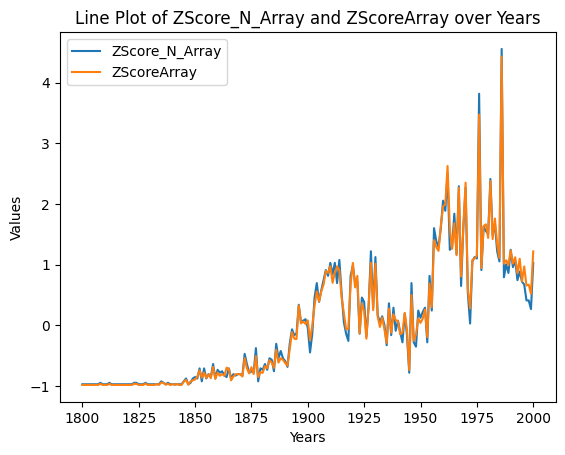

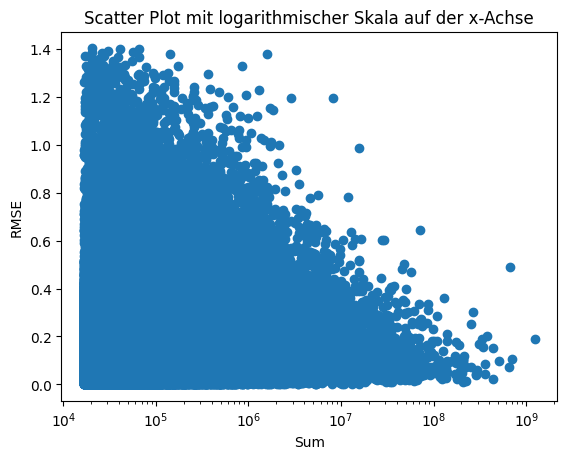

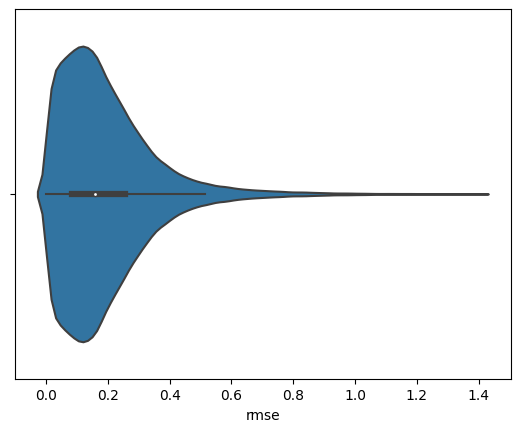

<Figure size 640x480 with 0 Axes>

In [4]:
final = spark.read.parquet("C:/Users/bincl/BA-Thesis/Dataset/final_df")
build_graph(final)

In [5]:
from pyspark.sql import functions as F
final.printSchema()

final.agg(F.min("rmse"), F.max("rmse"), F.min("sum"), F.max("sum"), F.avg("rmse")).show()


root
 |-- NgramId: long (nullable = true)
 |-- Sum: long (nullable = true)
 |-- rmse: double (nullable = true)
 |-- ZScore_N_Array: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- ZScoreArray: array (nullable = true)
 |    |-- element: double (containsNull = true)

File "token.parquet" not found. 
	 -- Creating "token.parquet" ...


AnalysisException: Path does not exist: file:/mnt/simhomes/binzc/data_transfer/1

In [ ]:
final.sort("rmse").show()

+------------+------+----+--------------------+--------------------+
|     NgramId|   Sum|rmse|      ZScore_N_Array|         ZScoreArray|
+------------+------+----+--------------------+--------------------+
| 85899355213|157933| 0.0|[-0.0707106781186...|[-0.0707106781186...|
| 77309415976|157832| 0.0|[-0.0707106781186...|[-0.0707106781186...|
| 34359744369| 39223| 0.0|[-0.0707106781186...|[-0.0707106781186...|
| 51539613495| 39049| 0.0|[-0.0707106781186...|[-0.0707106781186...|
| 68719480494|157832| 0.0|[-0.0707106781186...|[-0.0707106781186...|
| 94489288580| 39223| 0.0|[-0.0707106781186...|[-0.0707106781186...|
| 60129542977| 46757| 0.0|[-0.0707106781186...|[-0.0707106781186...|
| 94489285084| 22076| 0.0|[-0.0707106781186...|[-0.0707106781186...|
| 51539616492|158033| 0.0|[-0.0707106781186...|[-0.0707106781186...|
| 34359743745| 39223| 0.0|[-0.0707106781186...|[-0.0707106781186...|
|137438958073| 39223| 0.0|[-0.0707106781186...|[-0.0707106781186...|
| 51539608006| 39223| 0.0|[-0.0707